# Set-Up

In [3]:
#import base packages
from matplotlib import pyplot as plt
import cv2
import os
from glob import glob
import numpy as np
import pandas as pd
import seaborn as sns
import time
import tensorflow as tf

# make graphs pretty in ipynb notebooks
#%matplotlib inline

RANDOM_SEED = 9999

# ignore warnings
from sklearn.exceptions import DataConversionWarning
import warnings

warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings('ignore', category=DataConversionWarning)
warnings.simplefilter("ignore", category=PendingDeprecationWarning)
warnings.simplefilter('ignore', category=DeprecationWarning)

# Exploratory Data Analysis

In [4]:
# first explore the CSV files included with the image directory
samples = pd.read_csv('driver_imgs_list.csv')
samples.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [5]:
# see how many samples are included
print('Training Dataset Samples: {}'.format(samples.shape[0]))

# see number of classes
print('Number of Classes: {}' .format(len((samples['classname']).unique())))

Training Dataset Samples: 22424
Number of Classes: 10


In [6]:
# set key for classes with the associated distracted behavior
classes = {'c0': 'Safe Driving', 'c1': 'Texting - Right', 'c2': 'Talking on the Phone - Right',
          'c3': 'Texting - Left', 'c4': 'Talking on the Phone - Left', 'c5': 'Operating The Radio',
          'c6': 'Drinking', 'c7': 'Reaching Behind', 'c8': 'Hair and Makeup',
          'c9': 'Talkinng to Passenger'}

In [7]:
# see samples per class
samples_with_classes = samples.replace({'classname': classes})
class_count = samples_with_classes['classname'].value_counts().sort_values(ascending=True)
class_count

Hair and Makeup                 1911
Reaching Behind                 2002
Talkinng to Passenger           2129
Texting - Right                 2267
Operating The Radio             2312
Talking on the Phone - Right    2317
Drinking                        2325
Talking on the Phone - Left     2326
Texting - Left                  2346
Safe Driving                    2489
Name: classname, dtype: int64

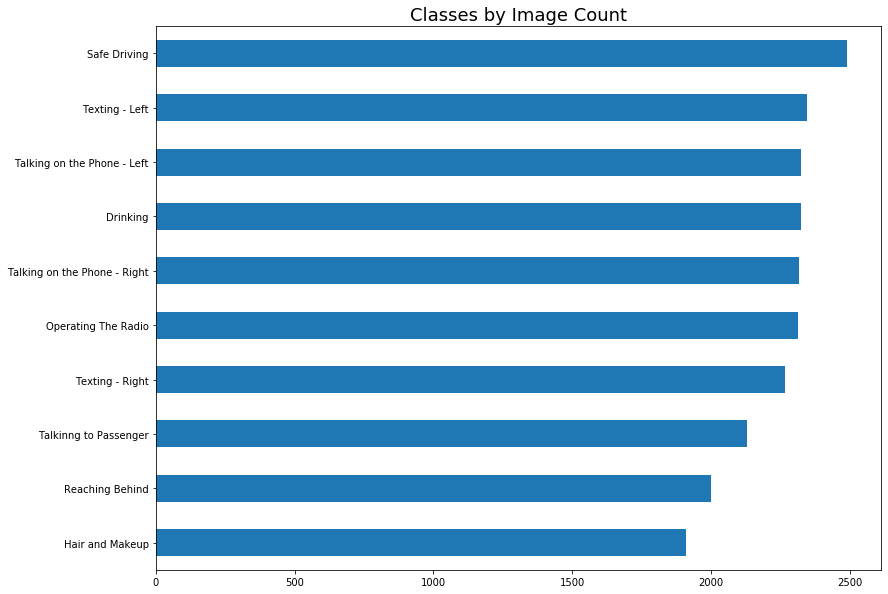

In [8]:
plt.figure(figsize=(13,10))
plt.title('Classes by Image Count', size=18)

class_count.plot.barh()

# Data Preparation

In [176]:
# define function to load the data
from sklearn.datasets import load_files
from keras.utils import np_utils

def load_train_data(path):
    dataset = load_files(path)
    file = np.array(dataset['filenames'])
    target = np_utils.to_categorical(np.array(dataset['target']),11)
    return file, target

#load train, test, and validation datasets from directory using load_data
# train_path = os.walk('imgs', 'train')
train_path = os.path.join('/mnt/N0360809/imgs', 'train')
print(os.path.exists(train_path))
train_img, train_target = load_train_data(train_path)

# load list of labels (classes)
labels = [item[11:13] for item in sorted(glob("/mnt/N0360809/imgs/train/*/"))]

True


In [11]:
# split into train/validation sets using a 80:20 split
from sklearn.model_selection import train_test_split

train, validation, train_targets, validation_targets = train_test_split(
    train_img, train_target, test_size=0.2, random_state=RANDOM_SEED)

In [177]:
# view the shape of the sets
print('Total images in Train Set: {}' .format(len(train)))
print('Total images in Validation Set: {}' .format(len(validation)))

Total images in Train Set: 17938
Total images in Validation Set: 4485


# Data Preprocessing

In [13]:
# define function to load images and converts them into 4D tensors
import PIL
from keras.preprocessing import image
from tqdm import tqdm


def load_img_to_tensor(path):
    # load RGB image using PIL and resizes to 224x224 (original input to VGG16)
    imgs = image.load_img(path, target_size=(224, 224))
    # convert image to an array
    x = image.img_to_array(imgs)
    # convert array into 4D tensor (1, 224, 224, 3) to load into CNN
 #   return np.expand_dims(x, axis=0)
    return np.expand_dims(x, axis=0)

# define function to convert array into 4D tensor with shape (samples, 224, 224, 3)
def load_arrays_to_tensor(paths):
    list_of_tensors = [load_img_to_tensor(path) for path in tqdm(paths)]
    return np.vstack(list_of_tensors)

In [14]:
# Data Normalization

# first verify image pixel range is 0-255
from numpy import asarray
from PIL import Image as PIL_Image

imagepath = os.path.join('/mnt/N0360809/imgs', 'train', 'c0', 'img_34.jpg')
test_image = PIL_Image.open(imagepath)
pixels = asarray(test_image)

print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

Data Type: uint8
Min: 0.000, Max: 255.000


In [15]:
# next normalize data to pixel range of 0-1
from PIL import ImageFile    

train_tensor = load_arrays_to_tensor(train).astype('float32')/255 
valid_tensor = load_arrays_to_tensor(validation).astype('float32')/255

100%|██████████| 15274/15274 [00:54<00:00, 281.14it/s]


# Model Set-Up

## Model: LeNet-5 Network (from scratch)

We will train a the data based on Yann Lecun's LeNet-5 model that was originally used to identify handwritten digits for zipcode recognition.

In [16]:
from keras.layers import Conv2D, MaxPool2D, AveragePooling2D
from keras.layers import Flatten, Dense
from keras.models import Sequential
def create_lenet5():
    model = Sequential()

    model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(224,224,3)))
    model.add(AveragePooling2D())

    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
    model.add(AveragePooling2D())

    model.add(Flatten())

    model.add(Dense(units=120, activation='relu'))

    model.add(Dense(units=84, activation='relu'))

    model.add(Dense(units=11, activation = 'softmax'))

    return model

In [178]:
# view LeNet-5 architecture summary
lenet5 = create_lenet5()
print("----------Summary of LeNet-5 Architecture:----------")
lenet5.summary()

----------Summary of LeNet-5 Architecture:----------
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 222, 222, 6)       168       
_________________________________________________________________
average_pooling2d_3 (Average (None, 111, 111, 6)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 109, 109, 16)      880       
_________________________________________________________________
average_pooling2d_4 (Average (None, 54, 54, 16)        0         
_________________________________________________________________
flatten_38 (Flatten)         (None, 46656)             0         
_________________________________________________________________
dense_124 (Dense)            (None, 120)               5598840   
_________________________________________________________________
d

In [167]:
from keras import optimizers
# compile the model using adam's and categorical crossentropy
# use accuracy as the metric to measure model performance
adam = optimizers.adam(lr=0.0001)

lenet5.compile(loss='categorical_crossentropy',optimizer=adam,
              metrics=['accuracy'])

## Train LeNet-5

We will now train the model using early stopping, where the model will stop training after the model stops improving

In [168]:
from keras.callbacks import EarlyStopping

callback = [EarlyStopping(monitor='val_loss', min_delta=0, 
                         patience=0, verbose=0, mode='auto', 
                         baseline=None, restore_best_weights=False)]

#define the number of epochs and batch size
epochs = 20
batch = 64

#initialize timer
start_time1 = time.clock()

#fit the model
lenet5.fit(train_tensor, train_targets, 
          validation_data=(valid_tensor, validation_targets),
          epochs=epochs, batch_size=batch, callbacks=callback, verbose=1)

#end timer
end_time1 = time.clock()

#save time
lenet5_time = end_time1 - start_time1

Train on 17938 samples, validate on 4485 samples
Epoch 1/20
17938/17938 [==============================] - 58s 3ms/step - loss: 0.0513 - accuracy: 0.9866 - val_loss: 0.0474 - val_accuracy: 0.9895
Epoch 2/20
17938/17938 [==============================] - 59s 3ms/step - loss: 0.0209 - accuracy: 0.9950 - val_loss: 0.0337 - val_accuracy: 0.9931
Epoch 3/20
17938/17938 [==============================] - 58s 3ms/step - loss: 0.0073 - accuracy: 0.9987 - val_loss: 0.0400 - val_accuracy: 0.9904


In [169]:
print("LeNet5 training took: {} seconds".format(lenet5_time))

LeNet5 training took: 4240.348712000065 seconds


In [170]:
scores = lenet5.evaluate(train_tensor, train_targets, verbose=1)

17938/17938 [==============================] - 17s 959us/step


In [171]:
print('LeNet-5 Model {}: {}%'.format(lenet5.metrics_names[1], round(scores[1]*100,2)))

LeNet-5 Model accuracy: 99.8%


## Transfer Learning: VGG16 Network

Next we will train the data based on the original VGG16 architecture implemented by Karen Simonyan and Andrew Zisserman where they investigated CNN performance with large-scale image recognition settings. (view [paper](https://arxiv.org/pdf/1409.1556.pdf) here)

In [132]:
from keras.applications.vgg16 import VGG16
# load VGG16 without the top layers
vgg16 = VGG16(weights = "imagenet", include_top = False, input_shape = (224, 224, 3))

# summarize the model
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [133]:
from keras.models import Model    
#Adding custom layers 
x = vgg16.output
x = Flatten()(x)
x = Dense(4096, activation="relu")(x)
x = Dense(4096, activation="relu")(x)
predictions = Dense(11, activation="softmax")(x)

vgg16_final = Model(inputs= vgg16.input, outputs= predictions)

In [134]:
# Freeze first 15 layers to not be trained
for layer in vgg16_final.layers[:15]:
    layer.trainable=False
for layer in vgg16_final.layers[15:]:
    layer.trainable=True

In [135]:
#List out all of the layers in the final model
for i,layer in enumerate(vgg16_final.layers):
    print(i,layer.name, layer.trainable)

0 input_21 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
19 flatten_31 True
20 dense_106 True
21 dense_107 True
22 dense_108 True


In [136]:
from keras import optimizers
# compile the model using adam's and categorical crossentropy
# use accuracy as the metric to measure model performance
adam = optimizers.adam(lr=0.0001)

vgg16_final.compile(loss='categorical_crossentropy',optimizer=adam,
              metrics=['accuracy'])

## Train VGG16

We will now train the model using early stopping, where the model will stop training after the model stops improving

In [137]:
from keras.callbacks import EarlyStopping

callback = [EarlyStopping(monitor='val_loss', min_delta=0, 
                         patience=0, verbose=0, mode='auto', 
                         baseline=None, restore_best_weights=False)]

#define the number of epochs and batch size
epochs = 20
batch = 64

# initialize timer
start_time2 = time.clock()

#fit the model
vgg16_final.fit(train_tensor, train_targets, 
          validation_data=(valid_tensor, validation_targets),
          epochs=epochs, batch_size=batch, callbacks=callback, verbose=1)

#end timer
end_time2 = time.clock()

#save time
vgg16_time = end_time2 - start_time2

Train on 17938 samples, validate on 4485 samples
Epoch 1/20
17938/17938 [==============================] - 551s 31ms/step - loss: 0.4759 - accuracy: 0.8414 - val_loss: 0.0670 - val_accuracy: 0.9837
Epoch 2/20
17938/17938 [==============================] - 550s 31ms/step - loss: 0.0374 - accuracy: 0.9891 - val_loss: 0.0532 - val_accuracy: 0.9851
Epoch 3/20
17938/17938 [==============================] - 550s 31ms/step - loss: 0.0173 - accuracy: 0.9952 - val_loss: 0.0395 - val_accuracy: 0.9902
Epoch 4/20
17938/17938 [==============================] - 549s 31ms/step - loss: 0.0166 - accuracy: 0.9951 - val_loss: 0.0324 - val_accuracy: 0.9918
Epoch 5/20
17938/17938 [==============================] - 554s 31ms/step - loss: 0.0177 - accuracy: 0.9945 - val_loss: 0.0392 - val_accuracy: 0.9895


In [138]:
print("VGG16 training took: {} seconds".format(vgg16_time))

VGG16 training took: 162585.23917699995 seconds


In [139]:
scores = vgg16_final.evaluate(train_tensor, train_targets, verbose=1)
print('VGG16 Model {}: {}%'.format(vgg16_final.metrics_names[1], round(scores[1]*100,2)))

17938/17938 [==============================] - 284s 16ms/step
VGG16 Model accuracy: 99.62%
